 # SWAP Test algorithm
 
We have the two input states $|\psi_1\rangle$ and $|\psi_2\rangle$ and our goal is to measure the inner product (overlap) or fidelity of these states using the SWAP test. We will later add depolarising error to gauge its effects on the measurement.

Starting with an initial state $|0,\psi_1,\psi_2\rangle$, we apply the Hadamard gate on the first qubit to get $(|0,\psi_1,\psi_2\rangle + |1,\psi_1,\psi_2\rangle)/\sqrt{2}$. Then, we apply the controlled-SWAP gate with the first qubit as control and the other qubits as targets to swap the two input states. We get $(|0,\psi_1,\psi_2\rangle +|1,\psi_2,\psi_1\rangle)/\sqrt{2}$. Then, we apply the Hadamard gate again on the first qubit to get $(|0,\psi_1,\psi_2\rangle + |1,\psi_1,\psi_2\rangle + |0,\psi_2,\psi_1\rangle - |1,\psi_2,\psi_1\rangle)/2 = |0\rangle [ |\psi_1,\psi_2\rangle + |\psi_2,\psi_1\rangle] /2 +  |1\rangle [|\psi_1,\psi_2\rangle  - |\psi_2,\psi_1\rangle]/2 $. Then, the probability of measuring the first qubit in $|0\rangle$ is $ [\langle\psi_1,\psi_2|+ \langle\psi_2,\psi_1|][ |\psi_1,\psi_2\rangle+ |\psi_2,\psi_1\rangle] /4 = 1/2 + |\langle \psi_1 | \psi_2 \rangle |^2/2 \equiv P_0$.

We obtain a good estimate for $P_0$ by measuring the final state of the first qubit over many shots. Then, we obtain the fidelity as:
$\mathcal{F}(|\psi_1\rangle,|\psi_2\rangle)=2P_0-1$.

# Depolarizing noise

Depolarising noise maps a density matrix $\rho$ into a linear combination of itself and the identity matrix, where the coefficients depend on the error rate $\lambda$, such that the density matrix with noise acted upon it is given as
$\rho_{f} = (1-\lambda)\rho + (\lambda/d) I$, where $d$ is the dimension of the Hilbert space. Thus, adding depolarising noise destroys the coherences (superposition) and the entanglement between qubits in the circuit. The resulting state becomes more and more mixed as the error rate is increased. 


# Effect of depolarizing noise on the SWAP test

At the maximum error rate, $\lambda=1$, the state becomes maximally mixed and is described as $\rho_{f} = (1/d) I$, such that the probability of measuring either $|0\rangle$, i.e., $P_0$, or $|1\rangle$, i.e., $1-P_0$ becomes equal, i.e., $P_0=1/2$. All information about the input states is lost and the fidelity, as defined earlier, reflects that as it becomes zero. However, the previously defined version of fidelity is no longer valid with noise due to the mixedness of the quantum state. The full state can only be described using the density matrix $\rho_f$ and the fidelity is defined as $Tr(\rho_1\rho_2)$, where $\rho_1 = |\psi_1\rangle  \langle\psi_1|$ and $\rho_2 = |\psi_2\rangle  \langle\psi_2|$. This mixedness cannot be measured as explained earlier using the Swap Test. 

Now, we will perform the SWAP test and vary the error rate $\lambda$ from 0 to 1 to demonstrate the effect of depolarizing noise on our circuit. We further compare how the number of gates to which the depolarizing noise is added plays a role in reducing the value of $\mathcal{F}$.

## Import libraries

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, execute
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise import depolarizing_error
from qiskit_aer import AerSimulator
from qiskit.quantum_info import DensityMatrix, partial_trace, purity

import math
import numpy as np
import matplotlib.pyplot as plt


## Circuit to initialize a desired state

In [2]:
def f_prep_state(statevec_list):
    
    '''
    statevec_list: list or numpy array of desired state
    
    output: circuit qc initializes qubits into state statevec_list
    '''
    
    n_qubits = int(np.log2(len(statevec_list)))
    qbits = QuantumRegister(n_qubits)
    qc = QuantumCircuit(qbits)
    
    # initialize state to statevec_list
    
    qc.initialize(statevec_list, qbits)
    
    return qc

## Circuit to implement a SWAP test

In [3]:
def f_SWAP_test(input1, input2):  
    
    '''
    input1: list or numpy array of desired state 1
    input2: list or numpy array of desired state 2
    
    output: circuit qc implements SWAP test on input1 and input2
    '''
    
    n_qubits = int(np.log2(len(input1)))
    qbits = QuantumRegister(1+2*n_qubits)
    cbits = ClassicalRegister(1)
    qc = QuantumCircuit(qbits, cbits)
    
    # apply Hadamard to ancilla
    qc.h(qbits[0])
    
    qc.barrier(qbits)
    
    # initialize input1
    state1 = f_prep_state(input1)
    list_qubits_comp = np.arange(1, n_qubits+1, 1)
    qc.compose(state1, qubits=list_qubits_comp, inplace=True)
    
    qc.barrier(qbits)
    
    # initialize input2
    state2 = f_prep_state(input2)
    list_qubits_comp = np.arange(n_qubits+1, 2*n_qubits+1, 1)
    qc.compose(state2, qubits=list_qubits_comp, inplace=True)
    
    qc.barrier(qbits)
    
    # apply controlled-SWAP gate to swap input1 and input2
    for i in range(1, n_qubits+1):
        qc.cswap(qbits[0],qbits[i],qbits[i+n_qubits])
        
    qc.barrier(qbits)
    
    # apply Hadamard to ancilla
    qc.h(qbits[0])
    
    
    # measure ancilla
    qc.measure(qbits[0],cbits[0])
    
    return qc
    

## Function to run SWAP test circuit with any given noise model

In [4]:
def f_run_SWAP_test(input1, input2, n_shots, input_noise_model):
    '''
    input1: list or numpy array of desired state 1
    input2: list or numpy array of desired state 2
    n_shots: number of shots for running simulator
    input_noise_model: noise model to be added to the simulator
    output: 
        fidelity: fidelity of input1 and input2 estimated using the SWAP test
        qc: quantum circuit of the SWAP test
    '''
    qc = f_SWAP_test(input1, input2)
    
    # Create noisy simulator backend
    sim_noise = AerSimulator(shots=n_shots, noise_model=input_noise_model)

    # Transpile circuit for noisy basis gates
    qc_noise = transpile(qc, sim_noise)

    result_noise = sim_noise.run(qc_noise).result()
    counts = result_noise.get_counts(0)

    
    # calculate fidelity from the measured counts
    fidelity = -1.0 + 2*counts['0']/n_shots
    return fidelity, qc_noise

# First noise model: add depolarizing error to the controlled-SWAP gates

In [14]:
# input1_list and input2_list are lists of input states corresponfing to the three user cases defined in the 
# problem in Task 4: 1-qubit, 2-qubit, and 3-qubit pairs of states

input1_list = ([np.sqrt(np.array([0.3,0.7])), np.sqrt(np.array([0.1,0.2,0.6,0.1])),
               np.sqrt(np.array([0.01,0.1,0.12,0.13,0.04,0,0.35,0.25]))])
input2_list = ([np.sqrt(np.array([0.6,0.4])), np.sqrt(np.array([0, 0.5,0.1,0.4])),
               np.sqrt(np.array([0,0.2,0.2,0.1,0.2,0.05,0.05,0.2]))])

# n_shots = number of measurement shots of quantum circuit to obtain the inner product/fidelity of states
n_shots = 20000

# prob_list = error probabilities' list
prob_list = np.linspace(0.01, 1, 11)

# fidelity list = measured fidelity of input1 and input2 for each error prob and user case
fidelity_list = np.zeros((len(prob_list),len(input1_list)))
num_total_gates = np.zeros((len(prob_list),len(input1_list)))
num_cswap_gates = np.zeros((len(prob_list),len(input1_list)))


for ip,prob in enumerate(prob_list):
    
    # Depolarizing quantum error applied to a 3-qubit gate
    error = depolarizing_error(prob, 3)

    # Add error to noise model
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['cswap'])
    
    # Run the simulator to measure fidelities of each user case for given error prob of cswap gate
    
    for i_in in range(0, len(input1_list)):
    
        input1 = input1_list[i_in]
        input2 = input2_list[i_in]

        fidelity, qc = f_run_SWAP_test(input1, input2, n_shots, noise_model)

        fidelity_list[ip,i_in] = fidelity
        dict_count_gates = dict(qc.count_ops())
        num_total_gates[ip,i_in] = (dict_count_gates['rz']+dict_count_gates['sx']+dict_count_gates['cswap'])
        num_cswap_gates[ip,i_in] = dict_count_gates['cswap']


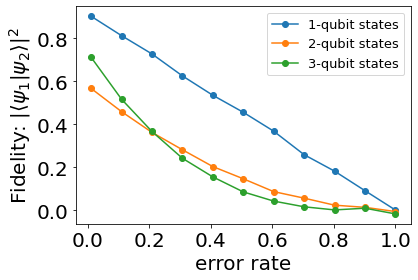

In [27]:
fs = 20

for i_in in range(0, len(input1_list)):
    plt.plot(prob_list, fidelity_list[:,i_in],'o-',label=str(i_in+1)+'-qubit states')
    
plt.ylabel('Fidelity: '+r'$|\langle \psi_1 | \psi_2 \rangle |^2$', fontsize=fs)
plt.xlabel('error rate',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(loc='best',fontsize=fs-7)
#plt.xscale('log')
#plt.yscale('log')
plt.show()



## Conclusions:

1. Fidelity goes down with increase in error rate, as expected.
2. Fidelity goes down faster for larger input states because the number of cswap gates is equal to $N$, where $N$ is also the number of qubits required to encode a quantum state. The error is applied to only the cswap gate, so the error increases with the number of times the cswap gate is applied.
    

# Second noise model: add depolarizing error to the $R_z$ gate

In [32]:
# input1_list and input2_list are lists of input states corresponfing to the three user cases defined in the 
# problem in Task 4: 1-qubit, 2-qubit, and 3-qubit pairs of states

input1_list = ([np.sqrt(np.array([0.3,0.7])), np.sqrt(np.array([0.1,0.2,0.6,0.1])),
               np.sqrt(np.array([0.01,0.1,0.12,0.13,0.04,0,0.35,0.25]))])
input2_list = ([np.sqrt(np.array([0.6,0.4])), np.sqrt(np.array([0, 0.5,0.1,0.4])),
               np.sqrt(np.array([0,0.2,0.2,0.1,0.2,0.05,0.05,0.2]))])

# n_shots = number of measurement shots of quantum circuit to obtain the inner product/fidelity of states
n_shots = 20000

# prob_list = error probabilities' list
prob_list = np.linspace(0.01, 1, 21)

# fidelity list = measured fidelity of input1 and input2 for each error prob and user case
fidelity_list = np.zeros((len(prob_list),len(input1_list)))
num_total_gates = np.zeros((len(prob_list),len(input1_list)))
num_rz_gates = np.zeros((len(prob_list),len(input1_list)))



for ip,prob in enumerate(prob_list):
    
    # Depolarizing quantum error applied to a 1-qubit gate
    error = depolarizing_error(prob, 1)

    # Add error to noise model
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['rz'])
    
    # Run the simulator to measure fidelities of each user case for given error prob of rz gate
    
    for i_in in range(0, len(input1_list)):
    
        input1 = input1_list[i_in]
        input2 = input2_list[i_in]

        fidelity, qc = f_run_SWAP_test(input1, input2, n_shots, noise_model)

        fidelity_list[ip,i_in] = fidelity
        dict_count_gates = dict(qc.count_ops())
        num_total_gates[ip,i_in] = (dict_count_gates['rz']+dict_count_gates['sx']+dict_count_gates['cx'])
        num_rz_gates[ip,i_in] = dict_count_gates['rz']


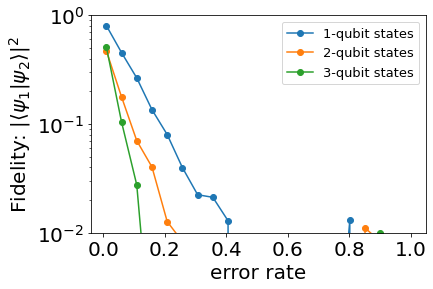

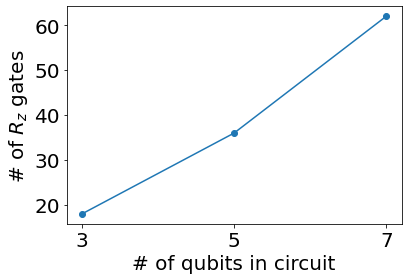

In [45]:
fs = 20


for i_in in range(0, len(input1_list)):
    plt.plot(prob_list, fidelity_list[:,i_in],'o-',label=str(i_in+1)+'-qubit states')
    
plt.ylabel('Fidelity: '+r'$|\langle \psi_1 | \psi_2 \rangle |^2$', fontsize=fs)
plt.xlabel('error rate',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(loc='best',fontsize=fs-7)
#plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-2,1])
plt.show()

plt.plot([2*1+1,2*2+1,2*3+1], num_rz_gates[0,:],'o-')
    
plt.ylabel(r'# of $R_z$ gates', fontsize=fs)
plt.xlabel('# of qubits in circuit',fontsize=fs)
plt.xticks([2*1+1,2*2+1,2*3+1],fontsize=fs)
plt.yticks(fontsize=fs)

plt.show()

## Conclusions:

Fidelity decays exponentially fast for all input states. The decay rate of fidelity is larger for larger input states. The number of gates with error also increases very quickly with the number of qubits in the circuit because $R_z$ gates are used in all parts of the circuit -- Hadamard gates, input state preparation, cswap gate, as shown below for a simple case of the 1-qubit state.

In [49]:
# Depolarizing quantum error applied to a 1-qubit gate
error = depolarizing_error(prob, 1)

# Add error to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error, ['rz'])

# Run the simulator to measure fidelities of each user case for given error prob of rz gate

i_in = 0

input1 = input1_list[i_in]
input2 = input2_list[i_in]

fidelity, qc = f_run_SWAP_test(input1, input2, n_shots, noise_model)


qc.draw()

global phase: π/8
         ┌─────────┐┌────┐┌─────────┐ ░                                    »
q5077_0: ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░────────────────────────────────────»
         └─────────┘└────┘└─────────┘ ░      ┌────────┐┌────┐┌────────────┐»
q5077_1: ─────────────────────────────░──|0>─┤ Rz(-π) ├┤ √X ├┤ Rz(1.1593) ├»
                                      ░      └────────┘└────┘└────────────┘»
q5077_2: ─────────────────────────────░────────────────────────────────────»
                                      ░                                    »
 c229: 1/══════════════════════════════════════════════════════════════════»
                                                                           »
«                ░                                           ░                 »
«q5077_0: ───────░───────────────────────────────────────────░─────────────────»
«         ┌────┐ ░                                           ░ ┌───┐           »
«q5077_1: ┤ √X ├─░───────────────────────────────────────────░─┤ X ├───────────»
«         └────┘ ░      ┌────────┐┌────┐┌────────────┐┌────┐ ░ └─┬─┘┌─────────┐»
«q5077_2: ───────░──|0>─┤ Rz(-π) ├┤ √X ├┤ Rz(1.7722) ├┤ √X ├─░───■──┤ Rz(π/2) ├»
«                ░      └────────┘└────┘└────────────┘└────┘ ░      └─────────┘»
« c229: 1/═════════════════════════════════════════════════════════════════════»
«                                                                              »
«                                                                            »
«q5077_0: ────────────────────────────────────■──────────────────────────────»
«                                             │                  ┌─────────┐ »
«q5077_1: ───────────────────■────────────────┼───────────────■──┤ Rz(π/4) ├─»
«         ┌────┐┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐┌─────────┐┌─┴─┐├─────────┴┐»
«q5077_2: ┤ √X ├┤ Rz(π/2) ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├»
«         └────┘└─────────┘└───┘└──────────┘└───┘└─────────┘└───┘└──────────┘»
« c229: 1/═══════════════════════════════════════════════════════════════════»
«                                                                            »
«                          ┌─────────┐                  ░ ┌─────────┐┌────┐»
«q5077_0: ──■───────■──────┤ Rz(π/4) ├──────■───────────░─┤ Rz(π/2) ├┤ √X ├»
«           │     ┌─┴─┐    ├─────────┴┐   ┌─┴─┐   ┌───┐ ░ └─────────┘└────┘»
«q5077_1: ──┼─────┤ X ├────┤ Rz(-π/4) ├───┤ X ├───┤ X ├─░──────────────────»
«         ┌─┴─┐┌──┴───┴───┐└──┬────┬──┘┌──┴───┴──┐└─┬─┘ ░                  »
«q5077_2: ┤ X ├┤ Rz(3π/4) ├───┤ √X ├───┤ Rz(π/2) ├──■───░──────────────────»
«         └───┘└──────────┘   └────┘   └─────────┘      ░                  »
« c229: 1/═════════════════════════════════════════════════════════════════»
«                                                                          »
«         ┌─────────┐┌─┐
«q5077_0: ┤ Rz(π/2) ├┤M├
«         └─────────┘└╥┘
«q5077_1: ────────────╫─
«                     ║ 
«q5077_2: ────────────╫─
«                     ║ 
« c229: 1/════════════╩═
«                     0

## Final conclusions:

1. The decay of fidelity has been used as a measure of mixedness of the system due to depolarizing noise.


2. The rate of increase of mixedness depends on three factors -- 
    
    (a) the error rate, 
    
    (b) the number of gates to which the noise is applied, and 
    
    (b) the number of qubits in the circuit. 
    
    
    Mixedness increases as each factor is increased.

3. To improve the performance of this quantum circuit under noise, we need to use error correction schemes, which can correct depolarizing, i.e., bit-flip errors. There are many such schemes (Steane code, Shor code, Bit-flip code, etc) and depending on the presence of other types of error, we can choose a scheme which fits best.